In [51]:
# fingerprint size:
# 1. simulate increasing n until I have no collision
# 2. use the results from the birthday paradox
# 3. theoretical formula
# 4. we should observe that the theory gives us very good approximation

# bit string array:
# 1.
# 2. check notes

# bloom filters:
# 1.
# 2. see notes
# 3.
# 4.
# 5.
# 6. just apply the formula (it should be quite accurate, if there are enough values in the set)

# for the table, since bit-string array and bloom filter depends on the number of bits, we can't just have a single
# number in the table, the table is there just to make us discuss our results

In [52]:
import numpy as np
import pandas as pd
import math
import re
from pympler import asizeof
import hashlib
import matplotlib.pyplot as plt

In [53]:
def read_clean_data(data_path):
    number_of_words = 0
    with open(data_path,'r') as file:
        data = file.read()

    data = re.sub(' +', ' ', data)
    data = re.sub('[\n]+', '\n', data)
    data = re.sub(r"[^\w\d'\s]+", '', data)
    data = data.lower()
    lines = data.split("\n")

    for line in lines:
        number_of_words += len(line.split())

    print("# of words:", number_of_words)
    print('# of verses:', len(lines))
    print('# of distinct verses:',len(set(data.split())))

    return data

In [54]:
def create_sentences(data, n):
    words = data.split()
    sentences = set()
    for i in range(len(data.split()) - n):
        sentence = " ".join(words[i:i+n])
        sentences.add(sentence)

    mem_occupancy = asizeof.asizeof(sentences)
    print("number of distinct sentences: ", len(sentences))
    print(f"actual memory occupancy of the set: {mem_occupancy} B ({mem_occupancy/(2**20)} MB)")

    return set(sentences)

In [55]:
text = read_clean_data("divina_commedia.txt")
sentences = create_sentences(text, 6)
avg_size = 0
for sentence in sentences:
    avg_size += asizeof.asizeof(sentence)
avg_size = avg_size / len(sentences)

print(f"Average size of each sentence: {avg_size} B")

# of words: 96730
# of verses: 14342
# of distinct verses: 13958
number of distinct sentences:  96700
actual memory occupancy of the set: 12987584 B (12.38592529296875 MB)
Average size of each sentence: 90.93137538779732 B


In [22]:
def get_hash(sentence, n):
    sentence_hash = hashlib.md5(sentence.encode('utf-8')) # md5 hash
    sentence_hash_int = int(sentence_hash.hexdigest(), 16) # md5 hash in integer format (convert to integer just to take less value since we don't need 128 bits hash
    h = sentence_hash_int % n # map into [0,n-1]
    return h

In [23]:
def get_bits_fingerprint(m, epsilon):
    b = math.log(m/epsilon, 2)
    return math.ceil(b)  # round up to the next integer

def get_range_fingerprint(m, epsilon):
    n = m/epsilon
    return math.ceil(n)  # round up to the next integer

def get_epsilon_fingerprint(m, b):
    return m / 2**b

In [24]:
class FingerprintSet:
    def __init__(self, data, b):
        self.data = data
        self.b = b
        self.n = 2**self.b
        self.m = len(self.data)  # maybe use len(data) instead

        self.fingerprint_set = self.fingerprints_set()

    def fingerprints_set(self):
        fingerprints_set = set()
        # m = len(self.data)
        # n = get_range_fingerprint(m, self.epsilon)
        # print(m, n)
        for line in self.data:
            h = get_hash(line, self.n)
            fingerprints_set.add(h)

        return fingerprints_set

    def get_fingerprints_set(self):
        return self.fingerprints_set()

    def get_p_collision_th(self, p=0.5):
        # 1-p = exp{-m**2 / 2n)
        # n = 2**b
        n = -(self.m**2) / (2*math.log(1-p))
        b = math.log(n, 2)

        return math.ceil(b)

    def is_collision(self):
        if len(self.data) == len(self.fingerprint_set):
            print("No collisions")
            return False
        else:
            print(f"{len(self.data) - len(self.fingerprint_set)} collisions")
            return True

    def get_collisions(self):
        return len(self.data) - len(self.fingerprint_set)

    def probability_fp(self, n):
        return 1 - (1 - 1/n)**self.m

    def get_actual_size(self):
        return asizeof.asizeof(self.fingerprint_set)

In [25]:
class FingerprintSetSimulator:
    def __init__(self):
        self.text = read_clean_data("divina_commedia.txt")
        self.sentences = create_sentences(self.text, 6)
        self.m = len(self.sentences)

        self.res = dict()

    def simulate(self):
        for b in range(16, 50): # starts from 16 bit fingerprints
            fingerprint_set = FingerprintSet(self.sentences, b)
            self.res[b] = fingerprint_set.get_collisions()

            if fingerprint_set.is_collision() is False:
                break

        print()
        print("# bits: ", b)
        print("theoretical # bits: ", fingerprint_set.get_p_collision_th())
        print("P(FP): ", fingerprint_set.probability_fp(2**b))
        print(f"actual memory occupancy: {fingerprint_set.get_actual_size()} B ({fingerprint_set.get_actual_size()/(2**20)} MB)")


    def plot(self):
        plt.figure(figsize=(10,7))
        plt.plot(list(self.res.keys()), list(self.res.values()), marker="o")
        plt.grid()
        plt.xlabel("# bits", fontsize=14)
        plt.ylabel("# collisions", fontsize=14)
        plt.savefig("n_collisions_fingerprint.png")
        plt.show()

# of words: 96730
# of verses: 14342
# of distinct verses: 13958
number of distinct sentences:  96700
actual memory occupancy of the set: 12987584 B (12.38592529296875 MB)
46201 collisions
28399 collisions
15934 collisions
8442 collisions
4315 collisions
2105 collisions
1077 collisions
501 collisions
234 collisions
121 collisions
53 collisions
29 collisions
15 collisions
9 collisions
6 collisions
3 collisions
No collisions

# bits:  32
theoretical # bits:  33
P(FP):  2.2514469789514102e-05
actual memory occupancy: 7288920 B (6.951255798339844 MB)


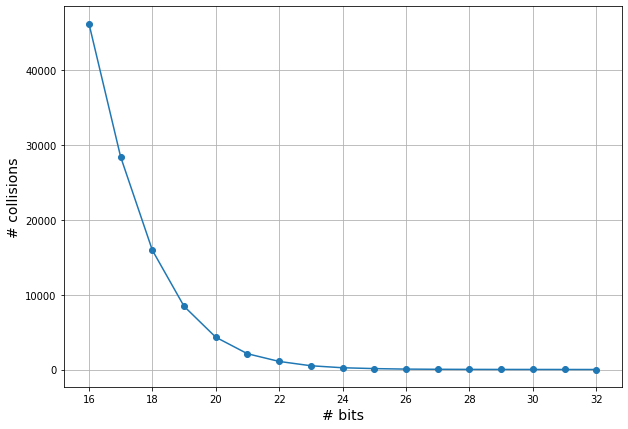

In [26]:
s = FingerprintSetSimulator()
s.simulate()
s.plot()

In [27]:
class BitStringArray:
    def __init__(self, data, n):
        self.data = data
        self.n = n
        self.bit_array = np.zeros(shape=self.n)

    def fill_array(self):
        for line in self.data:
            h = get_hash(line, self.n)
            self.bit_array[h] = 1

    def probability_fp(self):
        return np.sum(self.bit_array) / len(self.bit_array)

    def get_actual_size(self):
        return asizeof.asizeof(self.bit_array)

In [28]:
class BitStringArraySimulator:
    def __init__(self):
        self.text = read_clean_data("divina_commedia.txt")
        self.sentences = create_sentences(self.text, 6)

        self.res = dict()

    def simulate(self):
        for b in [19, 20, 21, 22, 23]:
            bit_array = BitStringArray(self.sentences, 2**b)
            bit_array.fill_array()
            p_fp = bit_array.probability_fp()
            self.res[b] = p_fp

            print("b: ", b)
            print("n: ", 2**b)
            print("P(FP): ", p_fp)
            print(f"actual memory occupancy: {bit_array.get_actual_size()} B ({bit_array.get_actual_size()/(2**20)} MB)")
            print("---------------------------")

    def plot(self):
        plt.figure(figsize=(10,7))
        plt.plot(list(self.res.keys()), list(self.res.values()), marker="o")
        plt.grid()
        plt.xlabel("# bits", fontsize=14)
        plt.ylabel("P(false positives)", fontsize=14)
        plt.savefig("p_fp_bitStringArray.png")
        plt.show()

# of words: 96730
# of verses: 14342
# of distinct verses: 13958
number of distinct sentences:  96700
actual memory occupancy of the set: 12987584 B (12.38592529296875 MB)
b:  19
n:  524288
P(FP):  0.16833877563476562
actual memory occupancy: 4194432 B (4.0001220703125 MB)
---------------------------
b:  20
n:  1048576
P(FP):  0.0881052017211914
actual memory occupancy: 8388736 B (8.0001220703125 MB)
---------------------------
b:  21
n:  2097152
P(FP):  0.04510641098022461
actual memory occupancy: 16777344 B (16.0001220703125 MB)
---------------------------
b:  22
n:  4194304
P(FP):  0.02279829978942871
actual memory occupancy: 33554560 B (32.0001220703125 MB)
---------------------------
b:  23
n:  8388608
P(FP):  0.011467814445495605
actual memory occupancy: 67108992 B (64.0001220703125 MB)
---------------------------


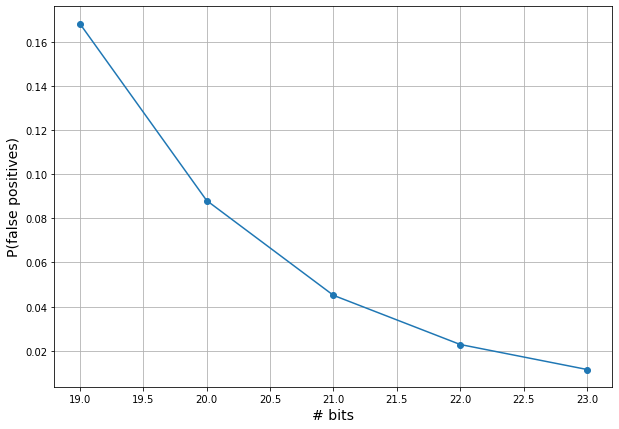

In [29]:
b = BitStringArraySimulator()
b.simulate()
b.plot()

In [30]:
class BloomFilter:
    def __init__(self, data, b, k):
        self.data = data
        self.b = b
        self.n = 2**self.b
        self.m = len(self.data)
        self.k = k

        self.bloom_filter = np.zeros(shape=self.n)
        self.estimated_stored_elements = self.fill_filter()  # fill the filter

    def insert(self, x):
        for i in range(self.k):
            if i == 0:
                h = get_hash(x, self.n)
            else:
                new_x = x + str(i)
                h = get_hash(new_x, self.n)

            self.bloom_filter[h] = 1

    def fill_filter(self):
        estimated_stored_elements = []

        for line in self.data:
            self.insert(line)
            estimated_stored_elements.append(self.distinct_elements_stored())

        return estimated_stored_elements

    def search(self, x):
        ans = True
        for i in range(self.k):
            if i == 0:
                h = get_hash(x, self.n)
            else:
                x = x + str(i)
                h = get_hash(x, self.n)

            if self.bloom_filter[h] == 0:
                ans = False
                break

        return ans

    def distinct_elements_stored(self):
        N = np.sum(self.bloom_filter)
        return -self.n/self.k * math.log(1 - N/self.n)


    def probability_fp(self):
        return (np.sum(self.bloom_filter) / len(self.bloom_filter))**self.k

    def get_estimated_stored_elements(self):
        return self.estimated_stored_elements

    def get_actual_size(self):
        return asizeof.asizeof(self.bloom_filter)

In [31]:
class BloomFilterSimulation:
    def __init__(self):
        self.text = read_clean_data("divina_commedia.txt")
        self.sentences = create_sentences(self.text, 6)

        self.res = dict()
        self.res_stored_elements = dict()

    def optimal_number_hash_functions(self, b):
        n = 2**b
        m = len(self.sentences)

        k = n/m * math.log(2)
        # two possible values as best
        k1 = math.floor(k)
        k2 = math.ceil(k)
        # compute the theoretical P(FP) of both values and use
        # the one with a lower probability
        p_fp1 = self.probability_fp_th(k1, m, n)
        p_fp2 = self.probability_fp_th(k2, m, n)

        if p_fp1 > p_fp2:
            return k2, p_fp2
        else:
            return k1, p_fp1

    def compute_optimal_number_has_functions(self):
        res_k = dict()
        res_p = dict()

        for b in [19, 20, 21, 22, 23]:
            k, p_fp = self.optimal_number_hash_functions(b)
            res_k[b] = k
            res_p[b] = p_fp
            print("b: ", b)
            print("\tp_fp: ", p_fp)
            print("\toptimal k: ", k)

        return res_k, res_p

    def probability_fp_th(self, k, m, n):
        return (1 - (1 - 1/n)**(m*k))**k

    def plot_optimal_k(self):
        res_k, res_p = self.compute_optimal_number_has_functions()

        plt.figure(figsize=(10,7))
        plt.plot(list(res_k.keys()), list(res_k.values()), marker="o")
        plt.grid()
        plt.xlabel("# bits", fontsize=14)
        plt.ylabel("k (optimal number of hash functions)", fontsize=14)
        plt.savefig("optimal_k.png")
        plt.show()

    def plot_optimal_k_p(self):
        res_k, res_p = self.compute_optimal_number_has_functions()

        fig,ax = plt.subplots(figsize=(10,7))
        ax.plot(list(res_k.keys()), list(res_k.values()), color='#1f77b4', marker="o")
        ax.set_xlabel("# bits", fontsize = 14)
        ax.set_ylabel("k (optimal number of hash functions)", color='#1f77b4', fontsize=14)
        ax2=ax.twinx()
        ax2.plot(list(res_p.keys()), list(res_p.values()),color='#ff7f0e', linestyle=':', marker="x")
        ax2.set_ylabel("theoretical P(false positive)",color='#ff7f0e', fontsize=14)
        ax.grid()
        plt.savefig("optimal_k.png")
        plt.show()

    def simulate(self):
        for b in [19, 20, 21, 22, 23]:
            k, th_p = self.optimal_number_hash_functions(b)  # compute optimal k
            bloom_filter = BloomFilter(self.sentences, b, k)  # create bloom filter

            self.res[b] = (bloom_filter.probability_fp(), th_p)  # evaluate the probability of false positive
            self.res_stored_elements[b] = bloom_filter.get_estimated_stored_elements()

            print("b: ", b)
            print("P(FP): ", bloom_filter.probability_fp())
            print(f"actual memory occupancy: {bloom_filter.get_actual_size()} B ({bloom_filter.get_actual_size()/(2**20)} MB)")
            print("---------------------------")

    def plot(self):
        p, th_p = [], []
        for _p, _th_p in self.res.values():
            p.append(_p)
            th_p.append(_th_p)

        plt.figure(figsize=(10,7))
        plt.plot(list(self.res.keys()), p, marker="o", label='simulated')
        plt.plot(list(self.res.keys()), th_p, marker="x", linestyle=':', label='theoretical')
        plt.grid()
        plt.xlabel("# bits", fontsize=14)
        plt.ylabel("P(false positives)", fontsize=14)
        plt.legend()
        plt.savefig("p_fp_bloom_filters.png")
        plt.show()

    def plot_inserted_elements_error(self):
        plt.figure(figsize=(10,7))

        for k, v in self.res_stored_elements.items():
            plt.plot(v - np.linspace(1, len(v), len(v)), label=f"b={k}")

        plt.grid()
        plt.legend()
        plt.xlabel("number of inserted element", fontsize=14)
        plt.ylabel("estimation of inserted elements error", fontsize=14)
        plt.savefig("estimation_inserted_elements_error.png")
        plt.show()


In [32]:
bf = BloomFilterSimulation()

# of words: 96730
# of verses: 14342
# of distinct verses: 13958
number of distinct sentences:  96700
actual memory occupancy of the set: 12987584 B (12.38592529296875 MB)


b:  19
	p_fp:  0.07414384286886169
	optimal k:  4
b:  20
	p_fp:  0.005497295257786453
	optimal k:  8
b:  21
	p_fp:  2.9839962583331274e-05
	optimal k:  15
b:  22
	p_fp:  8.904211578780568e-10
	optimal k:  30
b:  23
	p_fp:  7.928478713756954e-19
	optimal k:  60


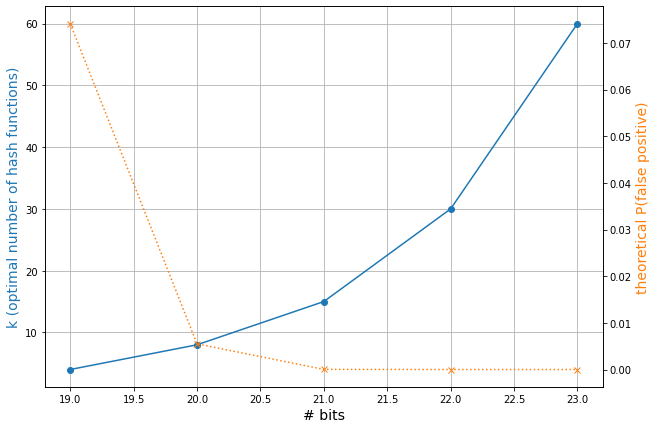

In [33]:
bf.plot_optimal_k_p()

b:  19
P(FP):  0.07436877992190073
actual memory occupancy: 4194432 B (4.0001220703125 MB)
---------------------------
b:  20
P(FP):  0.005492450660940125
actual memory occupancy: 8388736 B (8.0001220703125 MB)
---------------------------
b:  21
P(FP):  3.0026682166714118e-05
actual memory occupancy: 16777344 B (16.0001220703125 MB)
---------------------------
b:  22
P(FP):  8.916870695240416e-10
actual memory occupancy: 33554560 B (32.0001220703125 MB)
---------------------------
b:  23
P(FP):  7.8527901157876865e-19
actual memory occupancy: 67108992 B (64.0001220703125 MB)
---------------------------


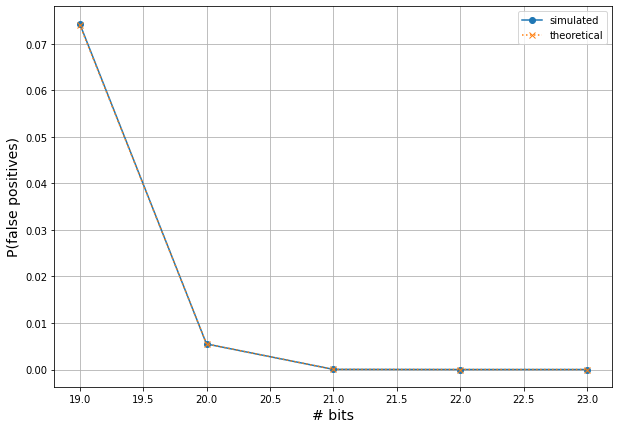

In [34]:
bf.simulate()
bf.plot()

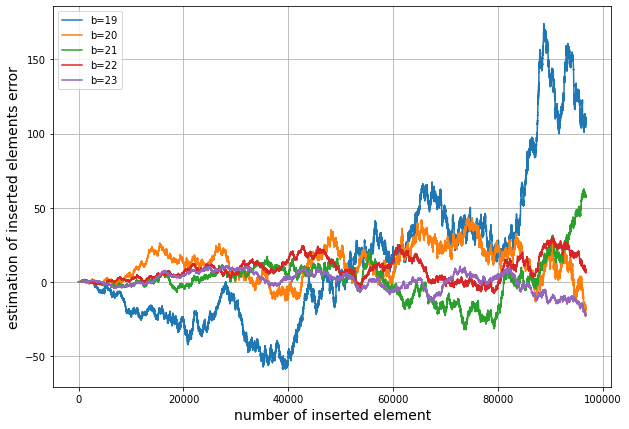

In [35]:
bf.plot_inserted_elements_error()

In [36]:
set_of_sentences_mem = 12987584

fingerprints_mem = {32: 7288920}
fingerprints_p_fp = {32: 2.2514469789514102e-05}

bitstring_array_mem = {
    19: 4194432,
    20: 8388736,
    21: 16777344,
    22: 33554560,
    23: 67108992
}
bitstring_array_p_fp = {
    19: 0.16833877563476562,
    20: 0.0881052017211914,
    21: 0.04510641098022461,
    22: 0.02279829978942871,
    23: 0.011467814445495605
}

bloom_filter_mem = {
    19: 4194432,
    20: 8388736,
    21: 16777344,
    22: 33554560,
    23: 67108992
}
bloom_filter_p_fp = {
    19: 0.07436877992190073,
    20: 0.005492450660940125,
    21: 3.0026682166714118e-05,
    22: 8.916870695240416e-10,
    23: 7.8527901157876865e-19
}

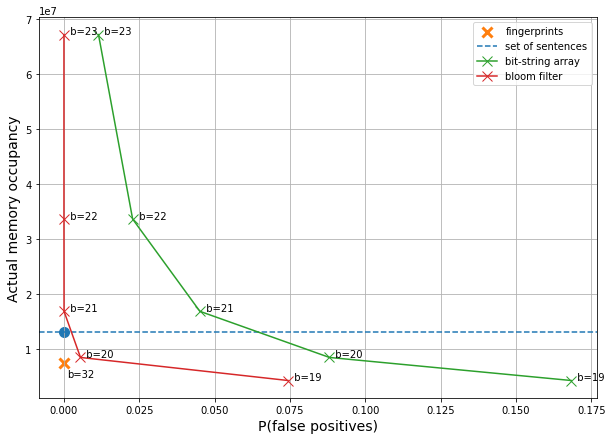

In [37]:
plt.figure(figsize=(10,7))
#plt.axhline(y=set_of_sentences_mem, label="set of sentences")
plt.scatter(0, set_of_sentences_mem, s=100)
plt.scatter(list(fingerprints_p_fp.values()), list(fingerprints_mem.values()), marker="x", label="fingerprints", s=100, linewidths=3)
plt.axhline(y=set_of_sentences_mem, linestyle="--", label="set of sentences")
# plt.axhline(y=list(fingerprints_mem.values())[0], linestyle="--", color='#ff7f0e', label="fingerprints")
plt.plot(list(bitstring_array_p_fp.values()), list(bitstring_array_mem.values()), label="bit-string array", marker="x", color='#2ca02c', markersize=10)
plt.plot(list(bloom_filter_p_fp.values()), list(bloom_filter_mem.values()), label="bloom filter", marker="x", color='#d62728', markersize=10)

for k in bitstring_array_p_fp.keys():
    plt.annotate(f"  b={k}", (bitstring_array_p_fp[k], bitstring_array_mem[k]), fontsize=10)
    plt.annotate(f"  b={k}", (bloom_filter_p_fp[k], bloom_filter_mem[k]), fontsize=10)
for k in fingerprints_p_fp.keys():
    # plt.annotate(f"  b={k}", (fingerprints_p_fp[k], fingerprints_mem[k]), fontsize=10)
    plt.text(fingerprints_p_fp[k]+.001, fingerprints_mem[k]-2500000, f"b={k}", fontsize=10)

plt.grid()
plt.legend()
plt.xlabel("P(false positives)", fontsize=14)
plt.ylabel("Actual memory occupancy", fontsize=14)
plt.savefig("summary.png")
plt.show()

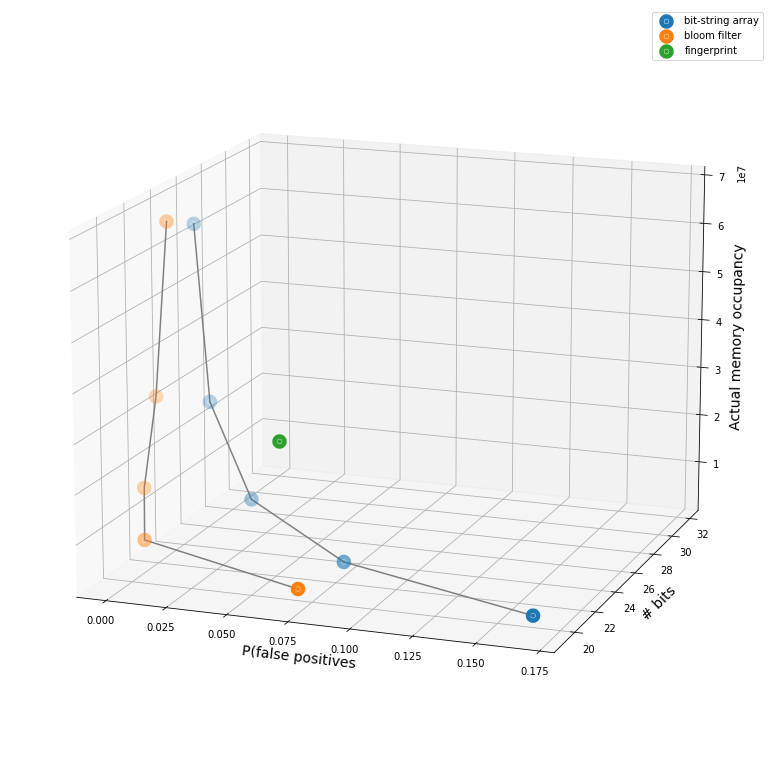

In [40]:
from mpl_toolkits import mplot3d

ax = plt.figure(figsize=(20,14)).add_subplot(projection='3d')

# Data for a three-dimensional line
zline = list(bitstring_array_p_fp.keys())
xline = list(bitstring_array_p_fp.values())
yline = list(bitstring_array_mem.values())
ax.plot3D(xline, zline, yline, 'gray')

# Data for three-dimensional scattered points
zdata = list(bitstring_array_p_fp.keys())
xdata = list(bitstring_array_p_fp.values())
ydata = list(bitstring_array_mem.values())
ax.scatter3D(xdata, zdata, ydata, linewidths=10, label="bit-string array")

zline = list(bloom_filter_p_fp.keys())
xline = list(bloom_filter_p_fp.values())
yline = list(bloom_filter_mem.values())
ax.plot3D(xline, zline, yline, 'gray')

# Data for three-dimensional scattered points
zdata = list(bloom_filter_p_fp.keys())
xdata = list(bloom_filter_p_fp.values())
ydata = list(bloom_filter_mem.values())
ax.scatter3D(xdata, zdata, ydata, linewidths=10, label="bloom filter")

# Data for three-dimensional scattered points
zdata = list(fingerprints_p_fp.keys())
xdata = list(fingerprints_p_fp.values())
ydata = list(fingerprints_mem.values())
ax.scatter3D(xdata, zdata, ydata, linewidths=10, label="fingerprint")

# # Data for three-dimensional scattered points
# zdata = 0
# xdata = 0
# ydata = set_of_sentences_mem
# # ax.scatter3D(xdata, zdata, ydata, linewidths=10, label="set of senteces")
#
# x = np.zeros(32)
# y = np.full(32, set_of_sentences_mem)
# z = np.linspace(-3, 31, 32)
#
# ax.plot3D(x, z, y, color='#d62728', linewidth=2, linestyle="--", label="set of senteces")
#
plt.legend()
ax.set_zlabel("Actual memory occupancy", fontsize=14)
ax.set_ylabel("# bits", fontsize=14)
ax.set_xlabel("P(false positives", fontsize=14)

from time import sleep
for angle in [0, 90, 180, 270, 290]:
    ax.view_init(elev=15, azim=angle)
    plt.savefig(f"./3Dres/{angle}.png")

plt.show()